In [29]:
import numpy as np
import pandas as pd
import tidyms as ms
import bokeh
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
from utils import data_container_from_csv

## Data loading

In [47]:
data = data_container_from_csv("data/progenesis-raw")

In [49]:
# add dilution information and sample mapping to data

def class_to_dil_factor(x):
    try:
        res = 1 / int(x)
    except ValueError:
        res = 1
    return res

data.dilution = data.classes.apply(class_to_dil_factor)


# "1", "2", "4", "8", "16" refers to dilution QC samples used to assess linearity of response
# pQC are process replicates from QC samples
mapping = {
    "qc": ["QC"],
    "sample": ["healthy", "post-surgery", "cancer", "benign", "SRM", "1", "2", "4", "8", "16", "pQC"],
    "blank": ["solvent", "process blank"],
    "dqc": ["1", "2", "4", "8", "16"]
}
data.mapping = mapping
data.set_plot_mode("seaborn")

# remove conditioning qcs
rmcqc = ms.filter.ClassRemover(["cQC", "zero"])
rmcqc.process(data)

# remove solvent at the end of each analytical batch
def get_last_sample_ind(df, n):
    return df.index[-n:]

ind = data.sample_metadata.groupby("batch").apply(lambda x: get_last_sample_ind(x, 2))
rm_sample = pd.Index([])
for i in ind.items():
    rm_sample = rm_sample.union(i[-1])
    
data.remove(rm_sample, "samples")

In [50]:
# creating a custom filter to remove features based on retention time
class RTFilter(ms.filter.Processor):
    
    def __init__(self, min_rt=None, max_rt=None, verbose=False):
        super(RTFilter, self).__init__("filter", "features", verbose=verbose)
        self.name = "RtFilter"
        if min_rt is None:
            min_rt = 0
        if max_rt is None:
            max_rt = np.inf
        self.params = {"min_rt": min_rt, "max_rt": max_rt}
        
    def func(self, dc):
        rt = dc.feature_metadata["rt"]
        min_rt = self.params["min_rt"]
        max_rt = self.params["max_rt"]
        invalid_rt = (rt < min_rt) | (rt > max_rt)
        rm_features = rt[invalid_rt].index
        return rm_features

Text(0.5, 1.0, 'PCA scores (antes del curado de datos)')

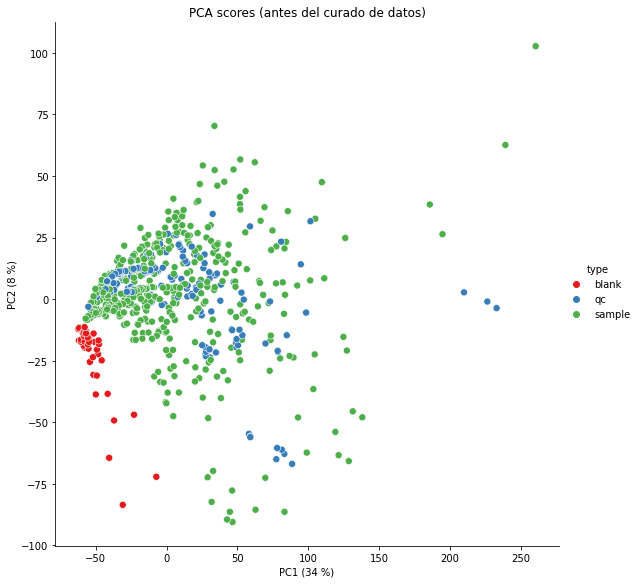

In [51]:
ignore = data.mapping["dqc"] + ["zero", "cQC"]
g = data.plot.pca_scores(
    scaling="autoscaling",
    ignore_classes=ignore,
    relplot_params={"s": 50, "height": 8, "palette": "Set1"},
    hue="type"
)
g.ax.set_title("PCA scores (antes del curado de datos)")
# g.savefig("pca-raw-qc-crm.png", dpi=150)

In [52]:
data.preprocess.correct_batches(n_jobs=2, verbose=True)

0 samples and 4416 features were removed


Correcting 2466 features in 23 batches:   0%|          | 0/56718 [00:00<?, ?it/s]

In [53]:
data.save("data/data-progenesis-batch-corrected.pickle")

In [54]:
%%time
rtf = RTFilter(min_rt=60, verbose=True)
bf = ms.filter.BlankCorrector(mode="loq", factor=1, robust=True)
pf = ms.filter.PrevalenceFilter(lb=1, process_classes=["QC"])
vf = ms.filter.VariationFilter(robust=True, ub=0.1)
df = ms.filter.DilutionFilter(mode="ols", plim=0, min_corr=0.9)
vf_pqc = ms.filter.VariationFilter(process_classes=["pQC"], ub=0.3)
crm = ms.filter.ClassRemover(data.mapping["blank"] + data.mapping["dqc"])

pipeline = ms.filter.Pipeline([rtf, bf, pf, df, crm], verbose=True)
pipeline.process(data)

Applying RtFilter: 845 features removed, 0 samples removed, Mean CV reduced by 0.81 %.
Applying Blank Corrector: 0 features removed, 0 samples removed, Mean CV reduced by 4.96 %.
Applying Prevalence Filter: 300 features removed, 0 samples removed, Mean CV reduced by 1.18 %.


/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: 

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/home/gabriel/miniconda3/envs/tidyms/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: Runtim

Applying Dilution Filter: 193 features removed, 0 samples removed, Mean CV reduced by 1.11 %.
Applying Class Remover: 0 features removed, 61 samples removed, Mean CV reduced by -25.72 %.
CPU times: user 5.03 s, sys: 350 ms, total: 5.38 s
Wall time: 4.91 s


In [55]:
data.save("data/progeneis-pca-filled-batch-corrected-partial-curation-no-cv-filter.pickle")

In [56]:
pipeline = ms.filter.Pipeline([vf, vf_pqc], verbose=True)
pipeline.process(data)

Applying Variation Filter: 6 features removed, 0 samples removed, Mean CV reduced by -0.07 %.
Applying Variation Filter: 360 features removed, 0 samples removed, Mean CV reduced by -8.91 %.


In [57]:
lacosamide_mz = 249.1249
lacosamide_rt = 3.85 * 60
lacosamide_ft = data.select_features(lacosamide_mz, lacosamide_rt)[0]

study_sample_mask = data.classes.isin(data.mapping["sample"])
lacosamide_mean = data.data_matrix.loc[study_sample_mask, lacosamide_ft].mean()
lacosamide_std = data.data_matrix.loc[study_sample_mask, lacosamide_ft].std()
n_std = 3
lacosamide_signal = data.data_matrix.loc[study_sample_mask, lacosamide_ft]
batches = data.batch[study_sample_mask]

outliers = lacosamide_signal.groupby(batches).apply(lambda x: ((x - x.mean()).abs() / x.std()) > n_std)
outliers = outliers[outliers].index

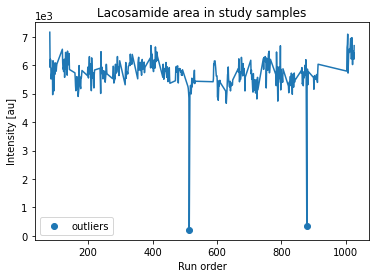

In [58]:
outlier_index = np.where(lacosamide_signal.index.isin(outliers))[0]
x = data.order[study_sample_mask].to_numpy()
y = lacosamide_signal.to_numpy()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(x[outlier_index], y[outlier_index], label="outliers")
ax.set_xlabel("Run order")
ax.set_ylabel("Intensity [au]")
ax.set_title("Lacosamide area in study samples")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.legend()

In [59]:
data.remove(outliers, "samples")

In [60]:
data.save("data/progenesis-pca-curated.pickle")

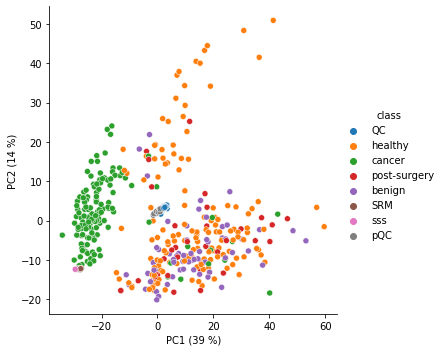

In [61]:
data.plot.pca_scores(scaling="autoscaling")